In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import re

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests

import copy
import itertools

from sklearn.preprocessing import StandardScaler

# Load Data

In [2]:
# Load the processsed data
name = 'CloudResearch-1_24.08.12'
df = pd.read_csv('/work/Processed Data/' + name + '_processed.csv')

In [3]:
df.columns = df.columns.str.replace(' ', '_').str.replace('-', '_').str.replace('/', '_')

In [4]:
# Dictionary to rename variables to more readable names
rename_dict = {'Frequency_Score_centered': 'Chatbot Usage Frequency',
 'Session_Length_Score_centered': 'Chatbot Session Length',
 'ULS_8_centered': 'Loneliness (ULS-8)',
 'SUS_Avg_centered': 'System Usability (SUS)',
 'BFI_Extraversion_centered': 'Extraversion (BFI-10)',
 'BFI_Neurotic_centered': 'Neuroticism (BFI-10)',
 'BFI_Agreeableness_centered': 'Agreeableness (BFI-10)',
 'BFI_Conscientious_centered': 'Conscientiousness (BFI-10)',
 'BFI_Openness_centered': 'Openness (BFI-10)',
 'LSNS_Score_centered': 'Socialization (LSNS)',
 'MSPSS_Score_centered': 'Perceived Social Support (MSPSS)',
 'B_RSES_Score_centered': 'Self-Esteem (B-RSES)',
 'AI_Attitudes_Score_centered': 'Attitudes towards AI',
 'C_State_Empathy_centered': 'State Empathy towards Chatbot',
 'C_SEmp_Affective_centered': 'Affective State Empathy towards Chatbot',
 'C_SEmp_Cognitive_centered': 'Cognitive State Empathy towards Chatbot',
 'C_SEmp_Associative_centered': 'Associative State Empathy towards Chatbot',
 'C_Social_Attract_centered': 'Social Attraction towards Chatbot',
 'C_Phys_Attract_centered': 'Physical Attraction towards Chatbot',
 'C_Task_Attract_centered': 'Task Attraction towards Chatbot',
 'C_Homophily_centered': 'Perceived Similarity with Chatbot',
 'C_Attrib_Conf_centered': 'Perceived Chatbot Predictability',
 'HCI_HHI_Expectation_centered': 'Expectations towards Chatbot (HCI/HHI)',
 'HCI_HHI_Trust_centered': 'Trust towards Chatbot (HCI/HHI)',
 'HCI_HHI_Substitution_centered': 'Preference for Chatbot over Humans (HCI/HHI)',
 'HHI_Trust___Unfam_centered': 'Trust in Unfamiliar People (HHI)',
 'HHI_CommIntent___Unfam_centered': 'Willingness to Engage with Unfamiliar People (HHI)',
 'HHI_Trust___Familiar_centered': 'Trust in Familiar People (HHI)',
 'HHI_CommIntent___Familiar_centered': 'Willingness to Engage with Familiar People (HHI)',
 'H_State_Empathy_centered': 'State Empathy towards Close Person',
 'H_SEmp_Affective_centered': 'Affective State Empathy towards Close Person',
 'H_SEmp_Cognitive_centered': 'Cognitive State Empathy towards Close Person',
 'H_SEmp_Associative_centered': 'Associative State Empathy towards Close Person',
 'H_Social_Attract_centered': 'Social Attraction towards towards Close Person',
 'H_Task_Attract_centered': 'Task Attraction towards towards Close Person',
 'H_Homophily_centered': 'Perceived Similarity with Close Person',
 'Age_centered': 'Age',
 'GPIUS2_centered': 'Problematic Use of Chatbot (GPIUS-2)',
 'Relation_Effect_1_centered': 'Chatbot Effect: Less Interaction with People',
 'Relation_Effect_2_centered': 'Chatbot Effect: Shift in Conversation Topics with People',
 'Relation_Effect_3_centered': 'Chatbot Effect: Easier to Talk to People',
 'Relation_Effect_4_centered': 'Chatbot Effect: More Enjoyable to Talk to People',
 'Relation_Effect_5_centered': 'Chatbot Effect: Less Engaging to Talk to People',
 'Relation_Effect_6_centered': 'Chatbot Effect: Less Interest in Talking to People'}

# Variable Exploration

In [5]:
# List of variables to include in regression model 
# (note: GPIUS is included for interest but not used in model)
variables = ['Frequency Score', 'Session Length Score', 
             'ULS-8', 'GPIUS2', 'SUS Avg', 'BFI Extraversion', 'BFI Neurotic', 'BFI Agreeableness', 
             'BFI Conscientious', 'BFI Openness', 'LSNS Score', 'MSPSS Score', 'B-RSES Score', 
             'AI Attitudes Score', 'C State Empathy', 'C SEmp Affective', 'C SEmp Cognitive', 
             'C SEmp Associative', 'C Social Attract', 'C Phys Attract', 'C Task Attract', 
             'C Homophily', 'C Attrib Conf', 'HCI-HHI Expectation', 'HCI-HHI Trust', 
             'HCI-HHI Substitution', 'HHI Trust - Unfam', 'HHI CommIntent - Unfam', 
             'HHI Trust - Familiar', 'HHI CommIntent - Familiar', 'H State Empathy', 
             'H SEmp Affective', 'H SEmp Cognitive', 'H SEmp Associative', 'H Social Attract', 
             'H Task Attract', 'H Homophily', 'Age']

# Replace spaces and hyphens in variable names
variables = [var.replace(' ', '_').replace('-', '_') for var in variables]
var_centered = [var + '_centered' for var in variables]

key_variables = ['Frequency_Score_centered', 'Session_Length_Score_centered', 'ULS_8_centered']

print(key_variables)
print(variables)

# Standardize variables
scaler = StandardScaler()
df[var_centered] = scaler.fit_transform(df[variables])

['Frequency_Score_centered', 'Session_Length_Score_centered', 'ULS_8_centered']
['Frequency_Score', 'Session_Length_Score', 'ULS_8', 'GPIUS2', 'SUS_Avg', 'BFI_Extraversion', 'BFI_Neurotic', 'BFI_Agreeableness', 'BFI_Conscientious', 'BFI_Openness', 'LSNS_Score', 'MSPSS_Score', 'B_RSES_Score', 'AI_Attitudes_Score', 'C_State_Empathy', 'C_SEmp_Affective', 'C_SEmp_Cognitive', 'C_SEmp_Associative', 'C_Social_Attract', 'C_Phys_Attract', 'C_Task_Attract', 'C_Homophily', 'C_Attrib_Conf', 'HCI_HHI_Expectation', 'HCI_HHI_Trust', 'HCI_HHI_Substitution', 'HHI_Trust___Unfam', 'HHI_CommIntent___Unfam', 'HHI_Trust___Familiar', 'HHI_CommIntent___Familiar', 'H_State_Empathy', 'H_SEmp_Affective', 'H_SEmp_Cognitive', 'H_SEmp_Associative', 'H_Social_Attract', 'H_Task_Attract', 'H_Homophily', 'Age']


In [6]:
# Check variables
df[var_centered].describe()

,Frequency_Score_centered,Session_Length_Score_centered,ULS_8_centered,GPIUS2_centered,SUS_Avg_centered,BFI_Extraversion_centered,BFI_Neurotic_centered,BFI_Agreeableness_centered,BFI_Conscientious_centered,BFI_Openness_centered,...,HHI_Trust___Familiar_centered,HHI_CommIntent___Familiar_centered,H_State_Empathy_centered,H_SEmp_Affective_centered,H_SEmp_Cognitive_centered,H_SEmp_Associative_centered,H_Social_Attract_centered,H_Task_Attract_centered,H_Homophily_centered,Age_centered
count,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,...,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02,4.040000e+02
mean,1.275108e-16,-4.396923e-17,-1.934646e-16,-1.846708e-16,2.638154e-16,1.121215e-16,1.450985e-16,4.836615e-17,-2.341361e-16,-8.793846e-17,...,-2.066554e-16,9.893076e-17,5.759969e-16,2.418308e-16,4.308984e-16,-2.682123e-16,-2.770061e-16,-1.758769e-17,-7.760569e-16,2.374338e-16
std,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,...,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00,1.001240e+00
min,-1.925119e+00,-1.014723e+00,-1.792966e+00,-1.394208e+00,-3.426758e+00,-1.679291e+00,-1.692860e+00,-1.450706e+00,-3.095353e+00,-3.092336e+00,...,-3.732899e+00,-3.554573e+00,-5.316461e+00,-4.870686e+00,-5.426415e+00,-4.578349e+00,-3.755138e+00,-4.051904e+00,-4.128058e+00,-1.663251e+00
25%,-5.550401e-01,-1.014723e+00,-7.777476e-01,-8.794627e-01,-6.925855e-01,-4.634603e-01,-8.052344e-01,-9.623020e-01,-5.093789e-01,-8.986506e-01,...,-5.096210e-01,-4.579746e-01,-4.931431e-01,-3.874725e-01,-6.249440e-01,-3.785693e-01,-8.505747e-01,-7.215720e-01,-5.459321e-01,-6.586860e-01
50%,1.299992e-01,1.099631e-01,6.826756e-02,-1.073448e-01,-4.501829e-02,1.444552e-01,8.239097e-02,1.450706e-02,1.711405e-01,1.981918e-01,...,2.961985e-01,3.161749e-01,1.767621e-01,-1.387133e-02,1.753012e-01,-2.858761e-02,2.665650e-01,1.665166e-01,1.363775e-01,-2.568602e-01
75%,8.150385e-01,1.099631e-01,7.450797e-01,6.647731e-01,8.184047e-01,7.523707e-01,6.371569e-01,5.029116e-01,7.155561e-01,7.466131e-01,...,6.991083e-01,7.032497e-01,7.126863e-01,7.333309e-01,9.755464e-01,1.021357e+00,9.368489e-01,8.325831e-01,6.481097e-01,5.467915e-01
max,8.150385e-01,4.608708e+00,2.267907e+00,3.238499e+00,2.082703e+00,3.184033e+00,1.857642e+00,2.456530e+00,1.259972e+00,1.295034e+00,...,1.102018e+00,1.090324e+00,1.114629e+00,1.106932e+00,9.755464e-01,1.021357e+00,9.368489e-01,1.054605e+00,1.671574e+00,3.861855e+00


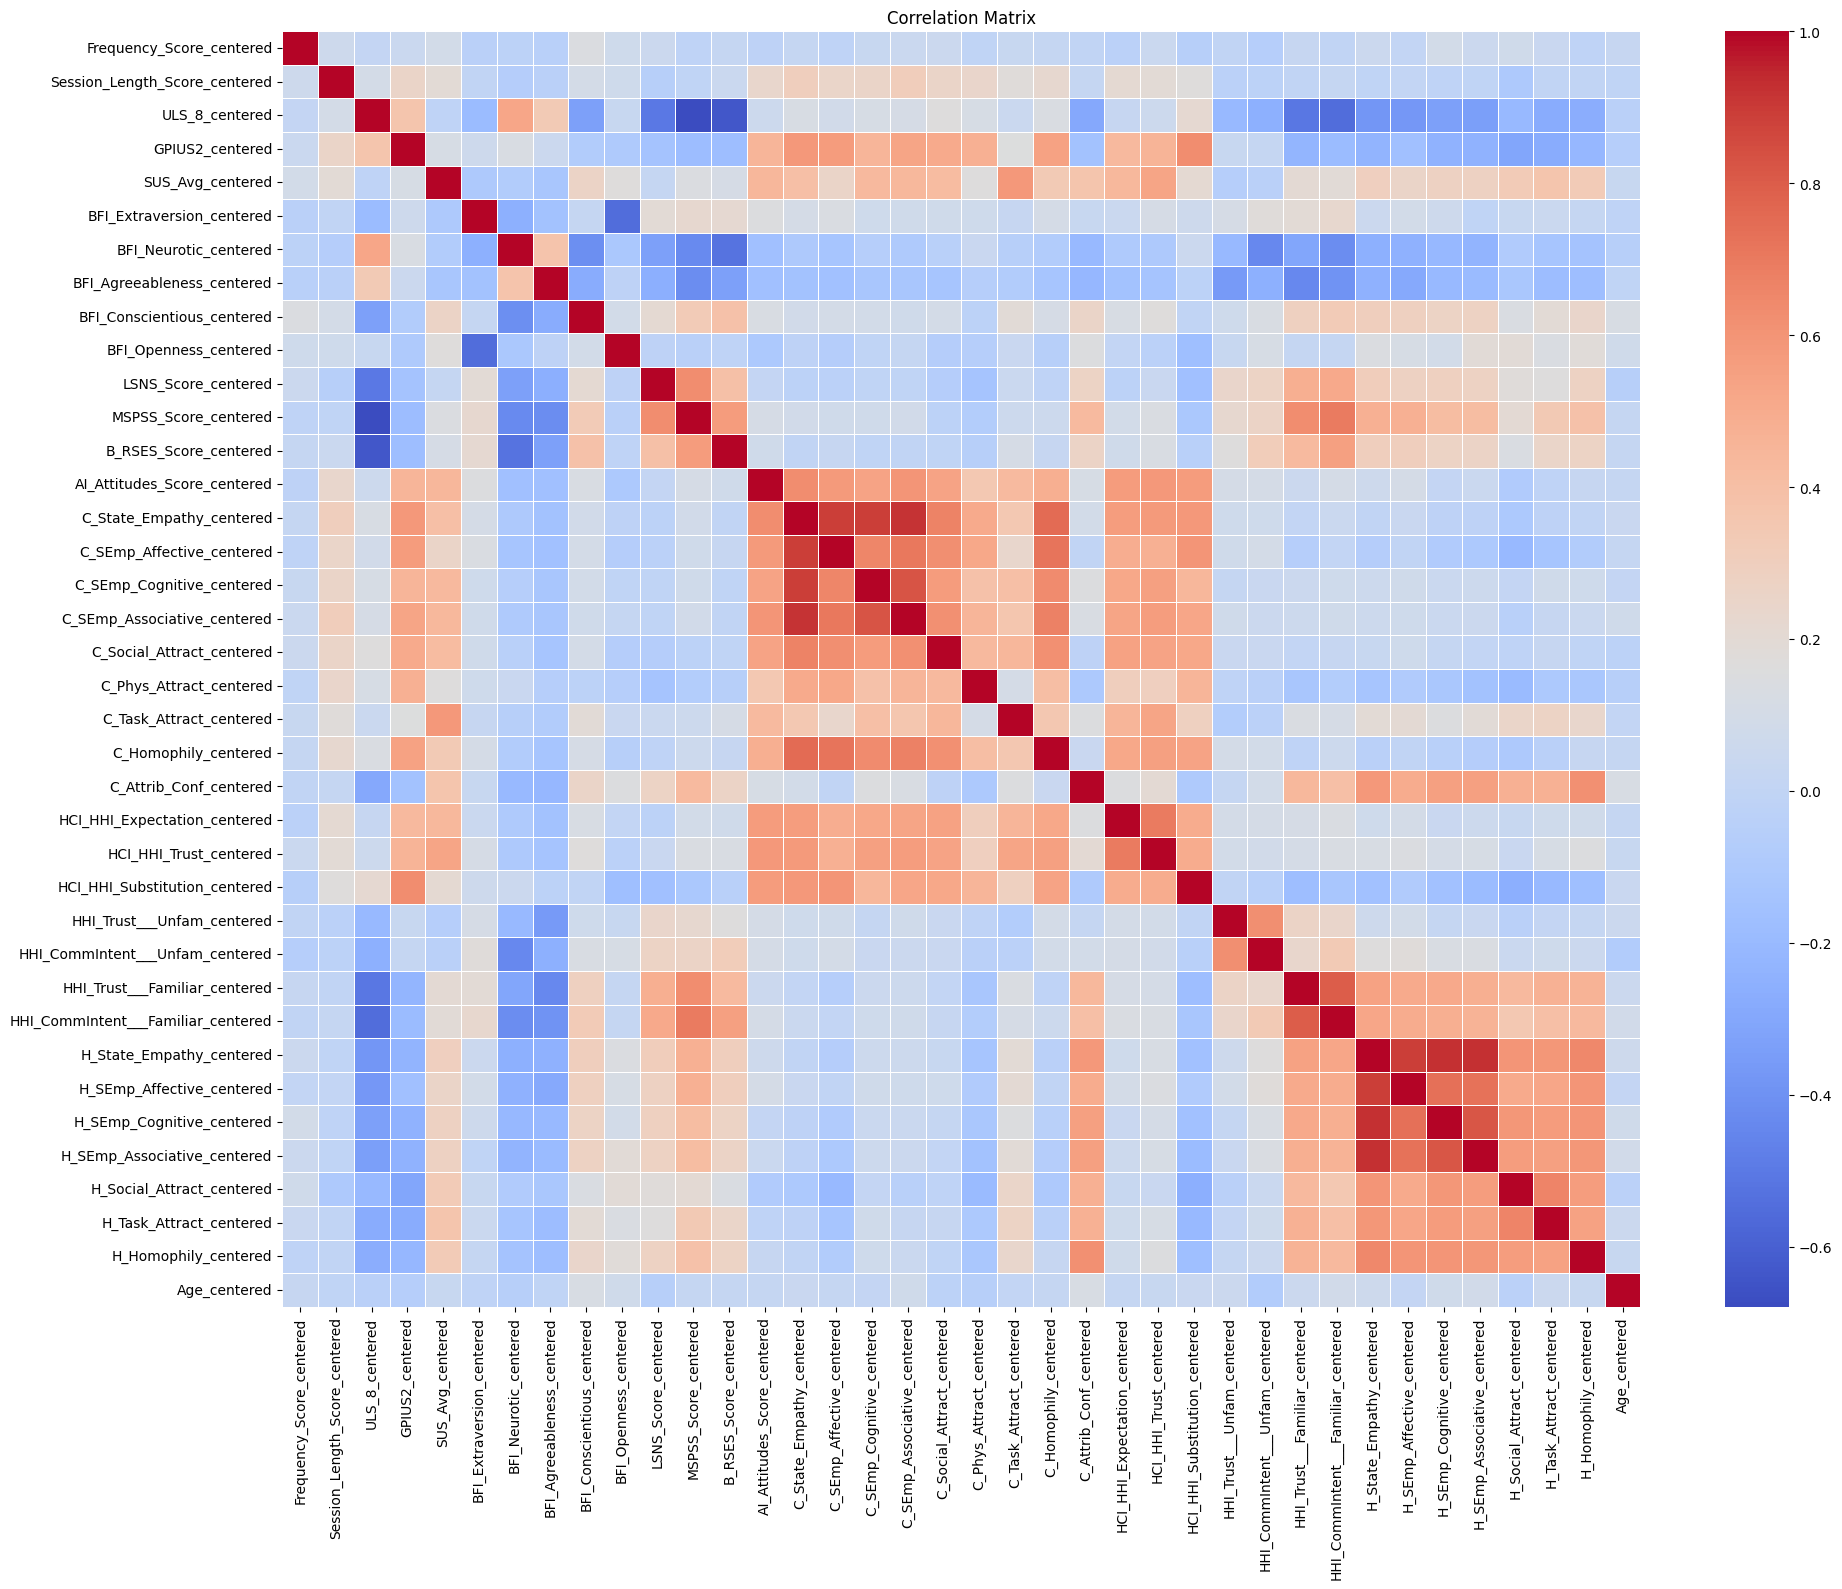

In [7]:
# Calculate spearman correlation
correlation_matrix = df[var_centered].corr(method='spearman', min_periods=1)

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate p-value & significant correlations

In [8]:
# Function to calculate p-value
def calculate_pvalue(r, n):
    if abs(r) == 1.0:
        return 0.0  # Perfect correlation, p-value is 0
    else:
        t = r * np.sqrt((n-2) / (1-r**2))
        p = 2 * (1 - stats.t.cdf(np.abs(t), n-2))
        return p

# Calculate p-values
n = df[var_centered].shape[0]  # sample size
p_values_matrix = correlation_matrix.applymap(lambda x: calculate_pvalue(x, n))

In [9]:
# Function to find significant correlations
def find_significant_correlations(correlation_matrix, p_values_matrix, key_variables, var_names, alpha=0.05):
    #significant_correlations = []
    for key_var in key_variables:
        print(f"\nSignificant correlations with {key_var}:")
        for var in var_names:
            if var != key_var:
                corr = correlation_matrix.loc[key_var, var]
                p_val = p_values_matrix.loc[key_var, var]
                if p_val < alpha:
                    # significant_correlations.append((key_var, var, corr, p_val))
                    print(f"{var}: correlation = {corr:.4f}, p-value = {p_val:.4f}")
    return #significant_correlation

# Function to visualize significant correlations
def significant_correlation_matrix(correlation_matrix, p_values_matrix, variables_of_interest, p_threshold=0.05, rename_dict=None, title=''):
    # Create a boolean mask for significant correlations
    significant_mask = (p_values_matrix < p_threshold) | (p_values_matrix.T < p_threshold)
    
    # Ensure variables of interest are always included
    for var in variables_of_interest:
        significant_mask[var] = True
        significant_mask.loc[var] = True
    
    # Apply the mask to get the significant correlation matrix
    significant_corr_matrix = correlation_matrix.loc[significant_mask.any(axis=1), significant_mask.any(axis=0)]

    # Create a copy for visualization
    viz_matrix = significant_corr_matrix.copy()

    # Rename the index and columns if a rename dictionary is provided
    if rename_dict:
        viz_matrix = viz_matrix.rename(index=rename_dict, columns=rename_dict)
        # Also rename the index and columns of the significant_mask
        significant_mask = significant_mask.rename(index=rename_dict, columns=rename_dict)
    
    # Create a mask for the heatmap to hide insignificant correlations
    heatmap_mask = ~significant_mask.loc[viz_matrix.index, viz_matrix.columns]
    
    # Set diagonal to False (to always show self-correlations)
    np.fill_diagonal(heatmap_mask.values, False)
    
    # Plot the heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(viz_matrix, 
                mask=heatmap_mask,
                annot=False, 
                cmap='coolwarm', 
                vmin=-1, 
                vmax=1, 
                center=0,
                square=True,
                linewidths=0.5)
    plt.title(title + ' ' f'Correlation Matrix (p < {p_threshold})')
    plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels
    plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal
    plt.tight_layout()
    plt.show()
    
    return significant_corr_matrix

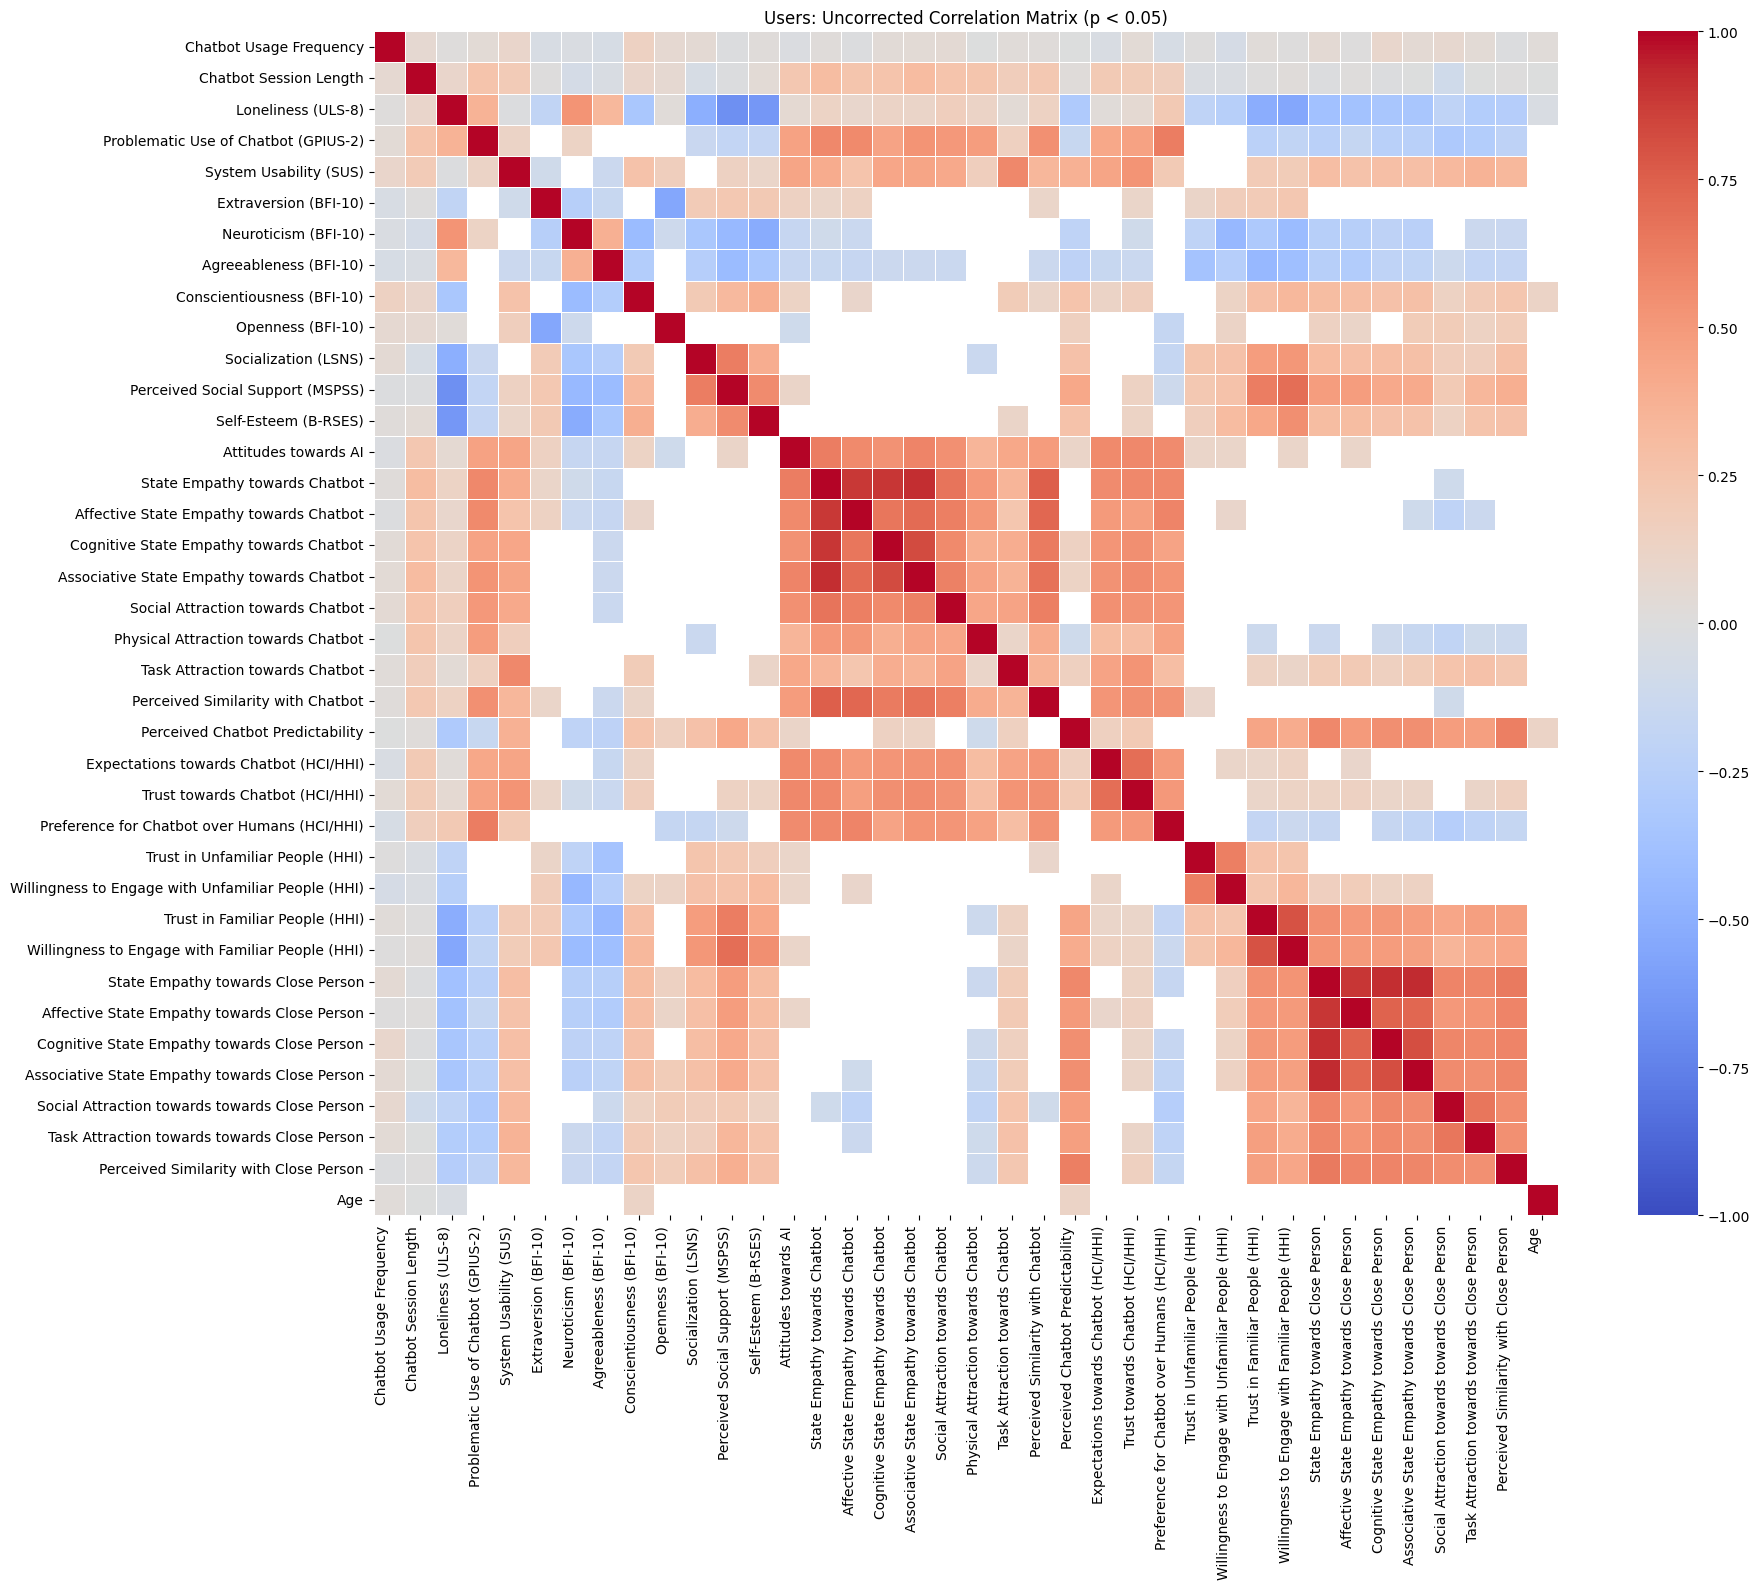

In [10]:
# Uncorrected significant correlations
significant_corr = significant_correlation_matrix(correlation_matrix, p_values_matrix, 
                                                key_variables, rename_dict=rename_dict, title='Users: Uncorrected')

# Apply Benjamini Hochberg correction

In [11]:
def apply_benjamini_hochberg(correlation_matrix, p_values_matrix, alpha=0.05):
    # Flatten the p-values matrix
    p_values_flat = p_values_matrix.values.flatten()
    
    # Apply Benjamini-Hochberg correction
    rejected, p_values_corrected, _, _ = multipletests(p_values_flat, alpha=alpha, method='fdr_bh')
    
    # Reshape the corrected p-values back into a matrix
    p_values_corrected_matrix = p_values_corrected.reshape(p_values_matrix.shape)
    
    # Create a DataFrame with the corrected p-values
    p_values_corrected_df = pd.DataFrame(p_values_corrected_matrix, 
                                         index=p_values_matrix.index, 
                                         columns=p_values_matrix.columns)
    
    # Create a mask for significant correlations
    significant_mask = p_values_corrected_df < alpha
    
    # Apply the mask to the correlation matrix
    correlation_matrix_significant = correlation_matrix.where(significant_mask)
    
    return correlation_matrix_significant, p_values_corrected_df

# Significant correlations after BH correction
correlation_matrix_significant, p_values_corrected = apply_benjamini_hochberg(correlation_matrix, p_values_matrix)

# Print the number of significant correlations
print(f"Number of significant correlations before BH correction: {significant_corr.notna().sum().sum() // 2}")
print(f"Number of significant correlations after BH correction: {correlation_matrix_significant.notna().sum().sum() // 2}")

Number of significant correlations before BH correction: 722
Number of significant correlations after BH correction: 403


In [12]:
# Print significant correlations
find_significant_correlations(correlation_matrix_significant, p_values_corrected, key_variables, var_centered)


Significant correlations with Frequency_Score_centered:
BFI_Conscientious_centered: correlation = 0.1411, p-value = 0.0093

Significant correlations with Session_Length_Score_centered:
GPIUS2_centered: correlation = 0.2549, p-value = 0.0000
SUS_Avg_centered: correlation = 0.1962, p-value = 0.0002
AI_Attitudes_Score_centered: correlation = 0.2331, p-value = 0.0000
C_State_Empathy_centered: correlation = 0.3016, p-value = 0.0000
C_SEmp_Affective_centered: correlation = 0.2475, p-value = 0.0000
C_SEmp_Cognitive_centered: correlation = 0.2539, p-value = 0.0000
C_SEmp_Associative_centered: correlation = 0.3073, p-value = 0.0000
C_Social_Attract_centered: correlation = 0.2553, p-value = 0.0000
C_Phys_Attract_centered: correlation = 0.2438, p-value = 0.0000
C_Task_Attract_centered: correlation = 0.1787, p-value = 0.0007
C_Homophily_centered: correlation = 0.2213, p-value = 0.0000
HCI_HHI_Expectation_centered: correlation = 0.2069, p-value = 0.0001
HCI_HHI_Trust_centered: correlation = 0.1938

# Visualizing the Corrected Correlation

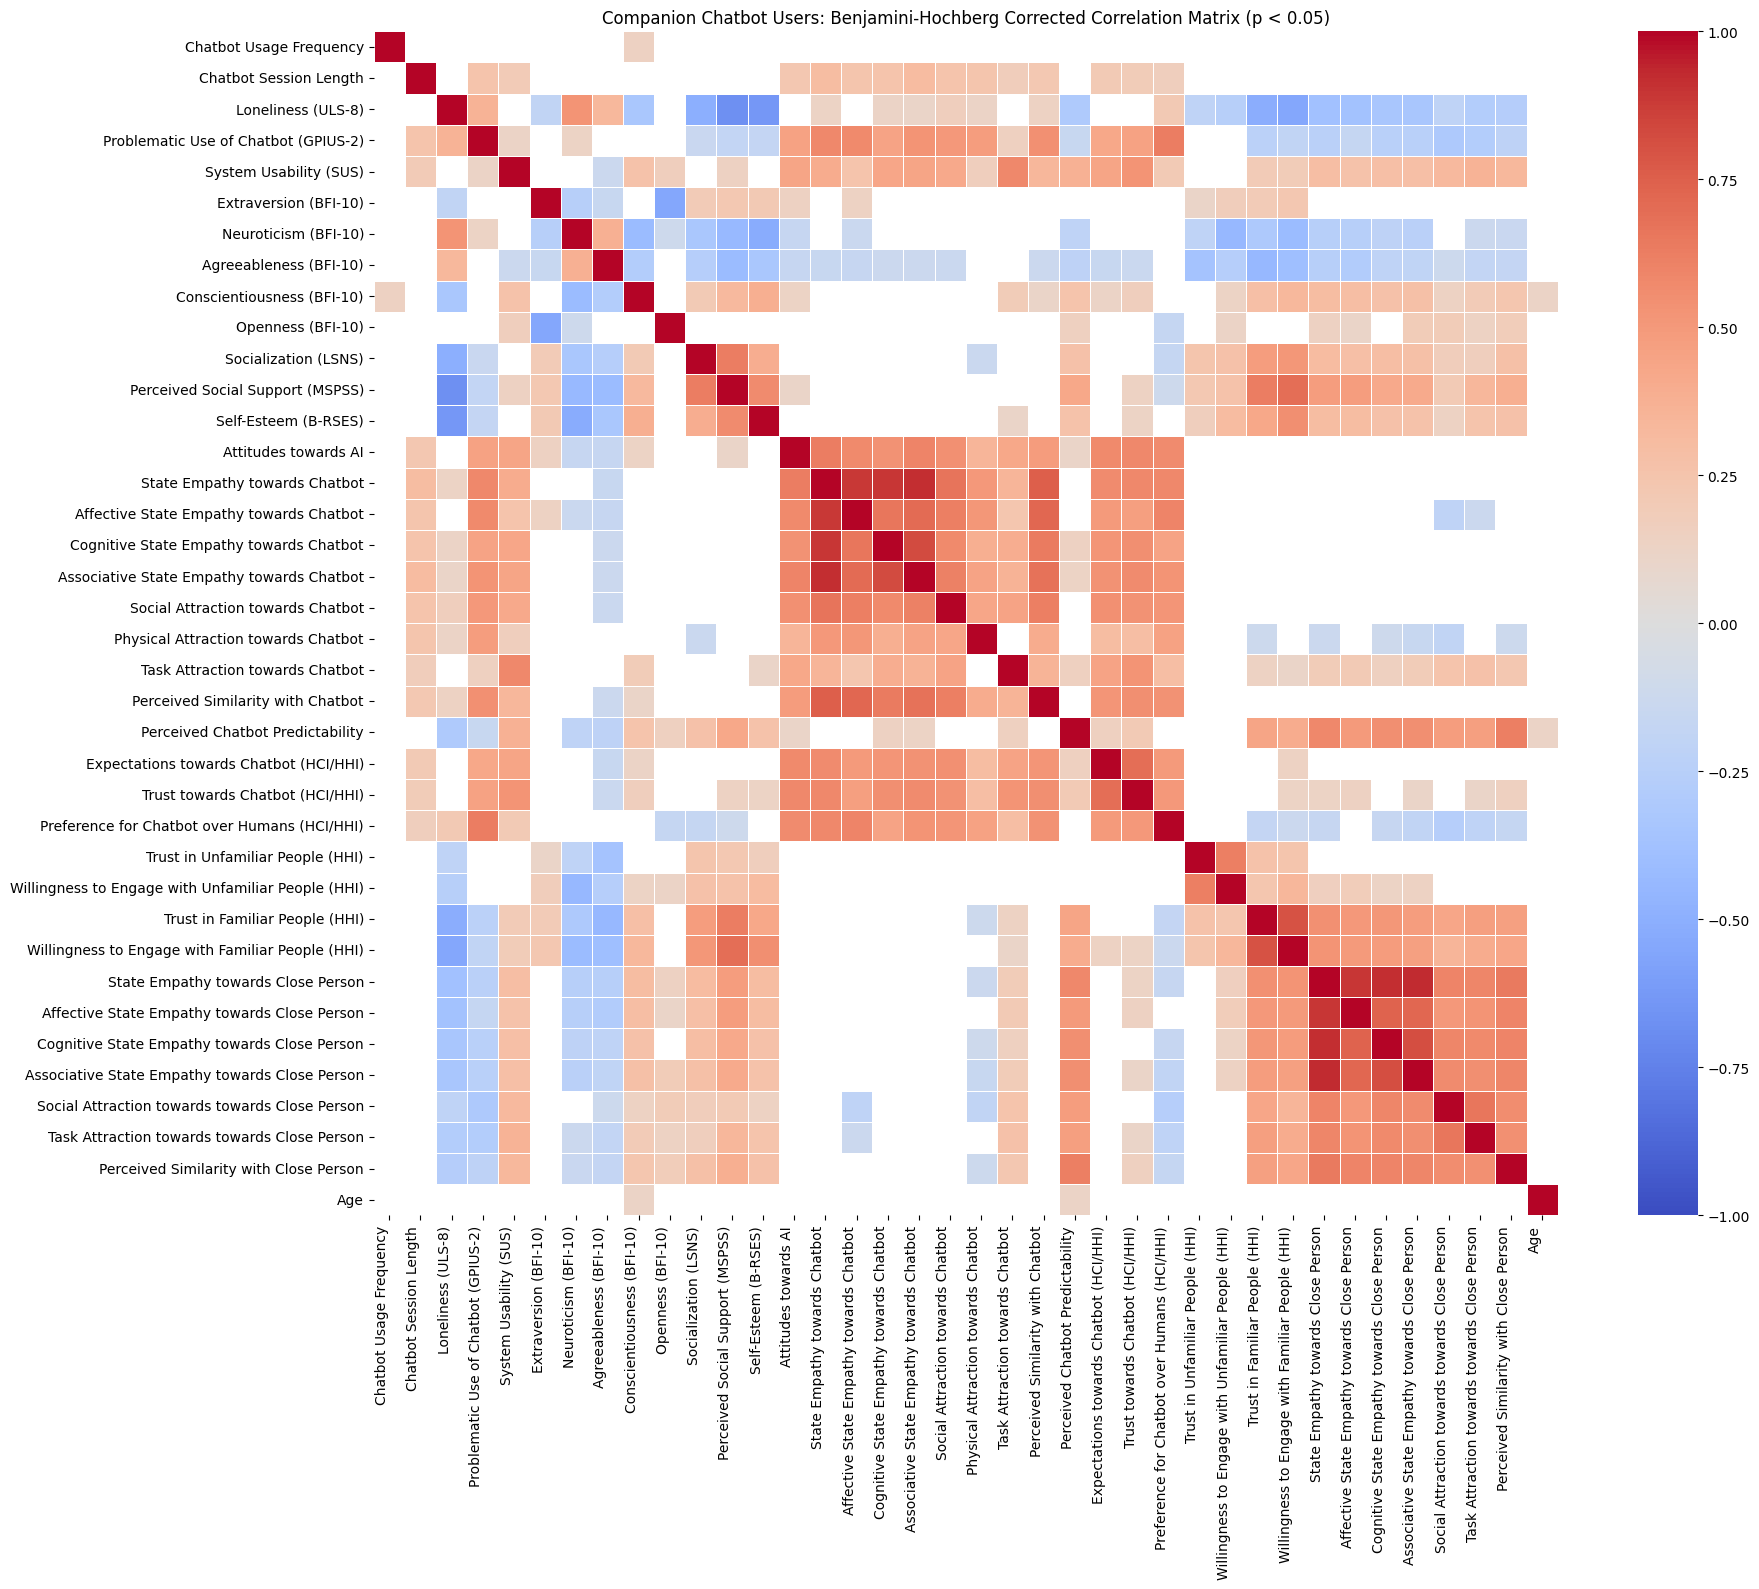

In [13]:
significant_corr = significant_correlation_matrix(correlation_matrix_significant, p_values_corrected, key_variables, rename_dict=rename_dict, title='Companion Chatbot Users: Benjamini-Hochberg Corrected')

# Mediation Analysis

In [14]:
# identify potential mediators

def identify_potential_mediators(correlation_matrix, p_values_matrix, x, y, threshold=0.05):
    potential_mediators = []
    for column in correlation_matrix.columns:
        if column not in [x, y]:
            p_value_x = p_values_matrix.loc[x, column]
            p_value_y = p_values_matrix.loc[y, column]
            if p_value_x < threshold and p_value_y < threshold:
                potential_mediators.append(column)
    return potential_mediators

x = 'Session_Length_Score_centered'
y = 'ULS_8_centered'
mediators = identify_potential_mediators(correlation_matrix, p_values_corrected, x, y)

print(f"Potential mediators: {mediators}")
print(len(mediators))

Potential mediators: ['GPIUS2_centered', 'C_State_Empathy_centered', 'C_SEmp_Cognitive_centered', 'C_SEmp_Associative_centered', 'C_Social_Attract_centered', 'C_Phys_Attract_centered', 'C_Homophily_centered', 'HCI_HHI_Substitution_centered']
8


In [15]:
def sanitize_variable_name(name):
    # Replace spaces with underscores
    name = name.replace(' ', '_')
    # If the name starts with a number, add 'x' prefix
    if name[0].isdigit():
        name = 'x' + name
    # If the name contains numbers (not at the start), wrap in Q()
    if any(char.isdigit() for char in name[1:]):
        name = f"Q('{name}')"
    return name

def create_formula(y, x_vars):
    y = sanitize_variable_name(y)
    x_vars = [sanitize_variable_name(x) for x in x_vars]
    return f"{y} ~ {' + '.join(x_vars)}"

def mediation_analysis(df, x, y, m):
    # Step 1: Regress Y on X
    formula_yx = create_formula(y, [x])
    model_yx = smf.ols(formula_yx, data=df).fit()
    c = model_yx.params[sanitize_variable_name(x)]
    
    # Step 2: Regress M on X
    formula_mx = create_formula(m, [x])
    model_mx = smf.ols(formula_mx, data=df).fit()
    a = model_mx.params[sanitize_variable_name(x)]
    
    # Step 3: Regress Y on both X and M
    formula_yxm = create_formula(y, [x, m])
    model_yxm = smf.ols(formula_yxm, data=df).fit()
    c_prime = model_yxm.params[sanitize_variable_name(x)]
    b = model_yxm.params[sanitize_variable_name(m)]
    
    # Calculate the indirect effect
    indirect_effect = a * b
    
    # Sobel test
    def sobel_test(a, b, sea, seb):
        z_value = a*b / np.sqrt(b**2 * sea**2 + a**2 * seb**2)
        p_value = 2 * (1 - stats.norm.cdf(abs(z_value)))
        return z_value, p_value
    
    z, p = sobel_test(a, b, model_mx.bse[sanitize_variable_name(x)], model_yxm.bse[sanitize_variable_name(m)])
    
    return {
        'mediator': m,
        'total_effect': c,
        'direct_effect': c_prime,
        'indirect_effect': indirect_effect,
        'a_path': a,
        'b_path': b,
        'sobel_z': z,
        'sobel_p': p
    }

# Conduct mediation analysis for each potential mediator
results = []
for mediator in mediators:
    result = mediation_analysis(df, x, y, mediator)
    results.append(result)
    print(f"\nMediation analysis for {mediator}:")
    for key, value in result.items():
        print(f"{key}: {value}")

# Create a summary dataframe
summary_df = pd.DataFrame(results)
summary_df = summary_df.sort_values('sobel_p')  # Sort by p-value of Sobel test

print("\nSummary of mediation analyses:")
summary_df


Mediation analysis for GPIUS2_centered:
mediator: GPIUS2_centered
total_effect: 0.0918826167741797
direct_effect: 0.00727963804617935
indirect_effect: 0.08460297872800043
a_path: 0.24412705250658018
b_path: 0.34655306677132824
sobel_z: 4.129149637293981
sobel_p: 3.641073860571886e-05

Mediation analysis for C_State_Empathy_centered:
mediator: C_State_Empathy_centered
total_effect: 0.0918826167741797
direct_effect: 0.06099976190997769
indirect_effect: 0.030882854864202
a_path: 0.2933342224535628
b_path: 0.10528214064450325
sobel_z: 1.9316227345701464
sobel_p: 0.05340608768640975

Mediation analysis for C_SEmp_Cognitive_centered:
mediator: C_SEmp_Cognitive_centered
total_effect: 0.0918826167741797
direct_effect: 0.0647647010531563
indirect_effect: 0.027117915721023348
a_path: 0.2304171302411776
b_path: 0.11769053669160373
sobel_z: 2.083317928822581
sobel_p: 0.037222253566912

Mediation analysis for C_SEmp_Associative_centered:
mediator: C_SEmp_Associative_centered
total_effect: 0.091882

,mediator,total_effect,direct_effect,indirect_effect,a_path,b_path,sobel_z,sobel_p
0,GPIUS2_centered,0.091883,0.007280,0.084603,0.244127,0.346553,4.129150,0.000036
4,C_Social_Attract_centered,0.091883,0.053901,0.037981,0.242619,0.156546,2.630776,0.008519
5,C_Phys_Attract_centered,0.091883,0.048412,0.043470,0.294669,0.147523,2.598576,0.009361
7,HCI_HHI_Substitution_centered,0.091883,0.059203,0.032680,0.152383,0.214458,2.522263,0.011660
6,C_Homophily_centered,0.091883,0.066234,0.025648,0.210622,0.121775,2.105468,0.035251
2,C_SEmp_Cognitive_centered,0.091883,0.064765,0.027118,0.230417,0.117691,2.083318,0.037222
1,C_State_Empathy_centered,0.091883,0.061000,0.030883,0.293334,0.105282,1.931623,0.053406
3,C_SEmp_Associative_centered,0.091883,0.061410,0.030472,0.290476,0.104904,1.924868,0.054246


In [16]:
# Choose mediators with p-value < 0.05
filtered_mediators = summary_df[summary_df['sobel_p'] < 0.05]['mediator'].tolist()

print(filtered_mediators)

['GPIUS2_centered', 'C_Social_Attract_centered', 'C_Phys_Attract_centered', 'HCI_HHI_Substitution_centered', 'C_Homophily_centered', 'C_SEmp_Cognitive_centered']


In [17]:
# Save the summary dataframe to a CSV file
fname = '/work/Output Data/' + name + '_mediation_analysis_summary_users.csv'
summary_df.to_csv(fname, index=False)
print("\nSummary saved to " + fname)


Summary saved to /work/Output Data/CloudResearch-1_24.08.12_mediation_analysis_summary_users.csv


# Moderation Analysis

In [18]:
def identify_potential_moderators(correlation_matrix, p_values_matrix, target_var, threshold=0.3, p_value_threshold=0.05):
    potential_moderators = []
    for column in correlation_matrix.columns:
        if column != target_var:
            corr = abs(correlation_matrix.loc[target_var, column])
            p_value = p_values_matrix.loc[target_var, column]
            if corr >= threshold and p_value <= p_value_threshold:
                potential_moderators.append((column, corr, p_value))
    
    # Sort by correlation strength (descending)
    potential_moderators.sort(key=lambda x: x[1], reverse=True)
    
    return potential_moderators

# Usage
target_var = 'ULS_8_centered' 
moderators = identify_potential_moderators(correlation_matrix, p_values_corrected, target_var)

print("Potential moderators (variable, correlation, p-value):")
for mod in moderators:
    print(f"{mod[0]}: correlation = {mod[1]:.4f}, p-value = {mod[2]:.4f}")


Potential moderators (variable, correlation, p-value):
MSPSS_Score_centered: correlation = 0.6790, p-value = 0.0000
B_RSES_Score_centered: correlation = 0.6380, p-value = 0.0000
HHI_CommIntent___Familiar_centered: correlation = 0.5495, p-value = 0.0000
BFI_Neurotic_centered: correlation = 0.5264, p-value = 0.0000
HHI_Trust___Familiar_centered: correlation = 0.5132, p-value = 0.0000
LSNS_Score_centered: correlation = 0.5055, p-value = 0.0000
H_State_Empathy_centered: correlation = 0.3821, p-value = 0.0000
H_SEmp_Affective_centered: correlation = 0.3725, p-value = 0.0000
GPIUS2_centered: correlation = 0.3649, p-value = 0.0000
H_SEmp_Associative_centered: correlation = 0.3382, p-value = 0.0000
H_SEmp_Cognitive_centered: correlation = 0.3377, p-value = 0.0000
BFI_Conscientious_centered: correlation = 0.3351, p-value = 0.0000
BFI_Agreeableness_centered: correlation = 0.3332, p-value = 0.0000


In [19]:
def moderation_analysis(df, x, y, moderator):
    # Create interaction term
    df['Interaction'] = df[x] * df[moderator]
    
    # Create formula
    formula = f"{y} ~ {x} + {moderator} + Interaction"
    
    # Fit the model
    model = smf.ols(formula, data=df).fit()
    
    # Extract key statistics
    coef = model.params['Interaction']
    p_value = model.pvalues['Interaction']
    r_squared = model.rsquared
    
    return {
        'moderator': moderator,
        'interaction_coef': coef,
        'interaction_p_value': p_value,
        'r_squared': r_squared
    }

def run_moderation_analyses(df, x, y, moderators):
    results = []
    for moderator in moderators:
        result = moderation_analysis(df, x, y, moderator[0])
        results.append(result)
    
    return pd.DataFrame(results)

x = 'Session_Length_Score_centered'
y = 'ULS_8_centered'

moderation_results = run_moderation_analyses(df, x, y, moderators)
print("Moderation Analysis Results:")
moderation_results

Moderation Analysis Results:


,moderator,interaction_coef,interaction_p_value,r_squared
0,MSPSS_Score_centered,0.011129,0.713491,0.490539
1,B_RSES_Score_centered,0.021356,0.501731,0.433489
2,HHI_CommIntent___Familiar_centered,0.054524,0.097132,0.325756
3,BFI_Neurotic_centered,-0.033828,0.452506,0.305429
4,HHI_Trust___Familiar_centered,0.051542,0.124990,0.289122
5,LSNS_Score_centered,0.012754,0.753437,0.265483
6,H_State_Empathy_centered,0.030583,0.497235,0.179006
7,H_SEmp_Affective_centered,0.033224,0.452196,0.168875
8,GPIUS2_centered,0.073424,0.119727,0.126692
9,H_SEmp_Associative_centered,0.026410,0.558972,0.149340


In [20]:
# moderators with p-value < 0.05
filtered_moderators = moderation_results[moderation_results['interaction_p_value'] < 0.05]['moderator'].tolist()

if len(filtered_moderators) == 0:
    print("No moderators pass the p-value threshold. Including most significant moderator.")
    # Include most significant moderator
    filtered_moderators = [moderation_results['moderator'].tolist()[-1]]

print(filtered_moderators)

No moderators pass the p-value threshold. Including most significant moderator.
['BFI_Agreeableness_centered']


In [21]:
# Save the moderation results to a CSV file
fname = '/work/Output Data/' + name + '_moderation_analysis_summary_users.csv'
moderation_results.to_csv(fname, index=False)
print("\nSummary saved to " + fname)


Summary saved to /work/Output Data/CloudResearch-1_24.08.12_moderation_analysis_summary_users.csv


# Identify Confounders

In [22]:
# Identify potential confounders
def identify_potential_confounders(correlation_matrix, p_values_matrix, x, y, corr_threshold=0.0, p_value_threshold=0.05):
    potential_confounders = []
    for column in correlation_matrix.columns:
        if column not in [x, y]:
            corr_x = abs(correlation_matrix.loc[x, column])
            corr_y = abs(correlation_matrix.loc[y, column])
            p_value_x = p_values_matrix.loc[x, column]
            p_value_y = p_values_matrix.loc[y, column]
            if (corr_x >= corr_threshold and p_value_x <= p_value_threshold) and \
               (corr_y >= corr_threshold and p_value_y <= p_value_threshold):
                potential_confounders.append((column, corr_x, p_value_x, corr_y, p_value_y))
    
    # Sort by sum of correlations (descending)
    potential_confounders.sort(key=lambda x: x[1] + x[3], reverse=True)
    
    return potential_confounders

confounders = identify_potential_confounders(correlation_matrix, p_values_corrected, x, y)
print("\nPotential confounders (variable, correlation with X, correlation with Y):")
for conf in confounders:
    print(f"{conf[0]}: corr with {x} = {conf[1]:.4f}, corr with {y} = {conf[3]:.4f}")


Potential confounders (variable, correlation with X, correlation with Y):
GPIUS2_centered: corr with Session_Length_Score_centered = 0.2549, corr with ULS_8_centered = 0.3649
C_State_Empathy_centered: corr with Session_Length_Score_centered = 0.3016, corr with ULS_8_centered = 0.1251
C_Social_Attract_centered: corr with Session_Length_Score_centered = 0.2553, corr with ULS_8_centered = 0.1658
C_SEmp_Associative_centered: corr with Session_Length_Score_centered = 0.3073, corr with ULS_8_centered = 0.1119
HCI_HHI_Substitution_centered: corr with Session_Length_Score_centered = 0.1684, corr with ULS_8_centered = 0.2138
C_SEmp_Cognitive_centered: corr with Session_Length_Score_centered = 0.2539, corr with ULS_8_centered = 0.1195
C_Phys_Attract_centered: corr with Session_Length_Score_centered = 0.2438, corr with ULS_8_centered = 0.1210
C_Homophily_centered: corr with Session_Length_Score_centered = 0.2213, corr with ULS_8_centered = 0.1364


In [23]:
confounders_list = [conf[0] for conf in confounders]

confounders_list.remove('GPIUS2_centered')
print(confounders_list)

['C_State_Empathy_centered', 'C_Social_Attract_centered', 'C_SEmp_Associative_centered', 'HCI_HHI_Substitution_centered', 'C_SEmp_Cognitive_centered', 'C_Phys_Attract_centered', 'C_Homophily_centered']


In [24]:
predictor_vars = list(set(filtered_mediators) | set(filtered_moderators) | set(confounders_list) | set(['LSNS_Score_centered', 'BFI_Neurotic_centered','H_Social_Attract_centered']))

# Added Neuroticism, LSNS, H Social Attract on theoretical basis
predictor_vars.remove('GPIUS2_centered')
predictor_vars = predictor_vars 
print(predictor_vars)

['BFI_Neurotic_centered', 'HCI_HHI_Substitution_centered', 'BFI_Agreeableness_centered', 'C_SEmp_Associative_centered', 'H_Social_Attract_centered', 'C_Homophily_centered', 'C_SEmp_Cognitive_centered', 'LSNS_Score_centered', 'C_Social_Attract_centered', 'C_State_Empathy_centered', 'C_Phys_Attract_centered']


# VIF Elimination

In [25]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.dropna().values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

vif_variables = ['ULS_8_centered', 'Session_Length_Score_centered'] + predictor_vars
X = df[vif_variables]

vif_results = calculate_vif(X)
print(vif_results)

                         Variable        VIF
11       C_State_Empathy_centered  19.426149
5     C_SEmp_Associative_centered   7.720489
8       C_SEmp_Cognitive_centered   6.593291
7            C_Homophily_centered   2.545852
10      C_Social_Attract_centered   2.150927
0                  ULS_8_centered   1.910872
3   HCI_HHI_Substitution_centered   1.889232
2           BFI_Neurotic_centered   1.597964
12        C_Phys_Attract_centered   1.478065
9             LSNS_Score_centered   1.414933
4      BFI_Agreeableness_centered   1.274316
6       H_Social_Attract_centered   1.210997
1   Session_Length_Score_centered   1.171278


In [26]:
# Remove state empathy subscales 
vif_variables = ['ULS_8_centered', 'Session_Length_Score_centered'] + predictor_vars
vif_variables.remove("C_SEmp_Associative_centered")
vif_variables.remove("C_SEmp_Cognitive_centered")
X = df[vif_variables]
vif_results = calculate_vif(X)
print(vif_results)

                         Variable       VIF
9        C_State_Empathy_centered  3.201017
6            C_Homophily_centered  2.510979
8       C_Social_Attract_centered  2.131912
0                  ULS_8_centered  1.901786
3   HCI_HHI_Substitution_centered  1.852316
2           BFI_Neurotic_centered  1.565640
10        C_Phys_Attract_centered  1.460838
7             LSNS_Score_centered  1.405861
4      BFI_Agreeableness_centered  1.270306
1   Session_Length_Score_centered  1.165806
5       H_Social_Attract_centered  1.161539


# Model Exploration

In [27]:
# Model variables - all variables in regression.
modelvars = vif_variables
adjusted_predictors = copy.deepcopy(modelvars)
adjusted_predictors.remove('Session_Length_Score_centered')
adjusted_predictors.remove('ULS_8_centered')
adjusted_predictors

['BFI_Neurotic_centered',
 'HCI_HHI_Substitution_centered',
 'BFI_Agreeableness_centered',
 'H_Social_Attract_centered',
 'C_Homophily_centered',
 'LSNS_Score_centered',
 'C_Social_Attract_centered',
 'C_State_Empathy_centered',
 'C_Phys_Attract_centered']

In [28]:
# Create interaction terms 
for term in adjusted_predictors:
    print(term)
    df[f'SLS_x_{term}'] = df['Session_Length_Score_centered'] * df[term]

BFI_Neurotic_centered
HCI_HHI_Substitution_centered
BFI_Agreeableness_centered
H_Social_Attract_centered
C_Homophily_centered
LSNS_Score_centered
C_Social_Attract_centered
C_State_Empathy_centered
C_Phys_Attract_centered


In [29]:
# Add sex and age as controls 
modelvars = modelvars + ['Sex'] + ['Age_centered']
adjusted_predictors = adjusted_predictors + ['Sex'] + ['Age_centered']
adjusted_predictors

['BFI_Neurotic_centered',
 'HCI_HHI_Substitution_centered',
 'BFI_Agreeableness_centered',
 'H_Social_Attract_centered',
 'C_Homophily_centered',
 'LSNS_Score_centered',
 'C_Social_Attract_centered',
 'C_State_Empathy_centered',
 'C_Phys_Attract_centered',
 'Sex',
 'Age_centered']

In [30]:
# Function for exploring models
def explore_ols(df, modelvars, subset_predictors, interaction_terms, x='Session_Length_Score_centered', y='ULS_8_centered', cat=[]): 
    # Filter rows where Age and other variables are not NaN
    df_filtered = df.dropna(subset=modelvars)

    interaction_names = [f'SLS_x_{term}' for term in interaction_terms]

    formula = f"{y} ~ {x}" 
    for var in subset_predictors + interaction_names + cat:
        formula += f" + {var}" 

    print(formula)

    # Fit the model with centered interaction term
    model = smf.ols(formula=formula, data=df_filtered).fit()

    print(model.summary())

In [31]:
model_specs = [] # list of tuples (model_name, subset_predictors, interaction_terms)

In [32]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('BFI_Neurotic_centered')
subset_predictors.remove('H_Social_Attract_centered')
interaction_terms = ['BFI_Agreeableness_centered']

model_specs.append(('Base Model', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + HCI_HHI_Substitution_centered + BFI_Agreeableness_centered + C_Homophily_centered + LSNS_Score_centered + C_Social_Attract_centered + C_State_Empathy_centered + C_Phys_Attract_centered + Sex + Age_centered + SLS_x_BFI_Agreeableness_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     18.31
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           2.23e-31
Time:                        18:03:55   Log-Likelihood:                -483.17
No. Observations:                 404   AIC:                             992.3
Df Residuals:                     391   BIC:                             1044.
Df Model:                          12                                         

In [33]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('H_Social_Attract_centered')
interaction_terms = ['BFI_Agreeableness_centered']

model_specs.append(('+ Neuroticism', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + BFI_Neurotic_centered + HCI_HHI_Substitution_centered + BFI_Agreeableness_centered + C_Homophily_centered + LSNS_Score_centered + C_Social_Attract_centered + C_State_Empathy_centered + C_Phys_Attract_centered + Sex + Age_centered + SLS_x_BFI_Agreeableness_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     26.57
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           4.59e-46
Time:                        18:03:55   Log-Likelihood:                -445.11
No. Observations:                 404   AIC:                             918.2
Df Residuals:                     390   BIC:                             974.2
Df Model:                          13                 

In [34]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('H_Social_Attract_centered')
subset_predictors.remove('C_Phys_Attract_centered')
subset_predictors.remove('HCI_HHI_Substitution_centered')
interaction_terms = ['BFI_Agreeableness_centered']

model_specs.append(('- C Phys Attract, HCI/HHI Substitution', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + BFI_Neurotic_centered + BFI_Agreeableness_centered + C_Homophily_centered + LSNS_Score_centered + C_Social_Attract_centered + C_State_Empathy_centered + Sex + Age_centered + SLS_x_BFI_Agreeableness_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     31.32
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           2.89e-47
Time:                        18:03:55   Log-Likelihood:                -445.84
No. Observations:                 404   AIC:                             915.7
Df Residuals:                     392   BIC:                             963.7
Df Model:                          11                                         
Covariance Type:            nonro

In [35]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('H_Social_Attract_centered')
subset_predictors.remove('C_Phys_Attract_centered')
subset_predictors.remove('HCI_HHI_Substitution_centered')
subset_predictors.remove('C_State_Empathy_centered')
subset_predictors.remove('C_Homophily_centered')
interaction_terms = ['BFI_Agreeableness_centered']

model_specs.append(('- C State Empathy, C Homophily', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + BFI_Neurotic_centered + BFI_Agreeableness_centered + LSNS_Score_centered + C_Social_Attract_centered + Sex + Age_centered + SLS_x_BFI_Agreeableness_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     37.61
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           5.83e-48
Time:                        18:03:55   Log-Likelihood:                -447.99
No. Observations:                 404   AIC:                             916.0
Df Residuals:                     394   BIC:                             956.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
    

In [36]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('H_Social_Attract_centered')
subset_predictors.remove('C_Phys_Attract_centered')
subset_predictors.remove('HCI_HHI_Substitution_centered')
subset_predictors.remove('C_State_Empathy_centered')
subset_predictors.remove('C_Homophily_centered')
interaction_terms = []

model_specs.append(('- SLSxAgreeableness', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + BFI_Neurotic_centered + BFI_Agreeableness_centered + LSNS_Score_centered + C_Social_Attract_centered + Sex + Age_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     42.42
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           8.65e-49
Time:                        18:03:55   Log-Likelihood:                -447.99
No. Observations:                 404   AIC:                             914.0
Df Residuals:                     395   BIC:                             950.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coe

In [37]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('C_Phys_Attract_centered')
subset_predictors.remove('HCI_HHI_Substitution_centered')
subset_predictors.remove('C_State_Empathy_centered')
subset_predictors.remove('C_Homophily_centered')
interaction_terms = []

model_specs.append(('+ H Social Attract', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + BFI_Neurotic_centered + BFI_Agreeableness_centered + H_Social_Attract_centered + LSNS_Score_centered + C_Social_Attract_centered + Sex + Age_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     39.27
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           1.18e-49
Time:                        18:03:55   Log-Likelihood:                -443.92
No. Observations:                 404   AIC:                             907.8
Df Residuals:                     394   BIC:                             947.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
           

## Explore interaction terms

In [38]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('C_Phys_Attract_centered')
subset_predictors.remove('HCI_HHI_Substitution_centered')
subset_predictors.remove('C_State_Empathy_centered')
subset_predictors.remove('C_Homophily_centered')
interaction_terms = ['C_Social_Attract_centered']

model_specs.append(('Explore: SLSxC Social Attract', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + BFI_Neurotic_centered + BFI_Agreeableness_centered + H_Social_Attract_centered + LSNS_Score_centered + C_Social_Attract_centered + Sex + Age_centered + SLS_x_C_Social_Attract_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     35.51
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           3.94e-49
Time:                        18:03:55   Log-Likelihood:                -443.22
No. Observations:                 404   AIC:                             908.4
Df Residuals:                     393   BIC:                             952.5
Df Model:                          10                                         
Covariance Type:            nonrobust                   

In [39]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('C_Phys_Attract_centered')
subset_predictors.remove('HCI_HHI_Substitution_centered')
subset_predictors.remove('C_State_Empathy_centered')
subset_predictors.remove('C_Homophily_centered')
interaction_terms = ['H_Social_Attract_centered']

model_specs.append(('Explore: SLSxH Social Attract', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + BFI_Neurotic_centered + BFI_Agreeableness_centered + H_Social_Attract_centered + LSNS_Score_centered + C_Social_Attract_centered + Sex + Age_centered + SLS_x_H_Social_Attract_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     36.16
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           7.42e-50
Time:                        18:03:55   Log-Likelihood:                -441.46
No. Observations:                 404   AIC:                             904.9
Df Residuals:                     393   BIC:                             948.9
Df Model:                          10                                         
Covariance Type:            nonrobust                   

In [40]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('C_Phys_Attract_centered')
subset_predictors.remove('HCI_HHI_Substitution_centered')
subset_predictors.remove('C_State_Empathy_centered')
subset_predictors.remove('C_Homophily_centered')
interaction_terms = ['BFI_Neurotic_centered']

model_specs.append(('Explore: SLSxNeuroticism', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + BFI_Neurotic_centered + BFI_Agreeableness_centered + H_Social_Attract_centered + LSNS_Score_centered + C_Social_Attract_centered + Sex + Age_centered + SLS_x_BFI_Neurotic_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     35.72
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           2.29e-49
Time:                        18:03:55   Log-Likelihood:                -442.65
No. Observations:                 404   AIC:                             907.3
Df Residuals:                     393   BIC:                             951.3
Df Model:                          10                                         
Covariance Type:            nonrobust                       

In [41]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('C_Phys_Attract_centered')
subset_predictors.remove('HCI_HHI_Substitution_centered')
subset_predictors.remove('C_State_Empathy_centered')
subset_predictors.remove('C_Homophily_centered')
interaction_terms = ['BFI_Agreeableness_centered']

model_specs.append(('Explore: SLSxAgreeableness', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + BFI_Neurotic_centered + BFI_Agreeableness_centered + H_Social_Attract_centered + LSNS_Score_centered + C_Social_Attract_centered + Sex + Age_centered + SLS_x_BFI_Agreeableness_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     35.25
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           7.64e-49
Time:                        18:03:55   Log-Likelihood:                -443.91
No. Observations:                 404   AIC:                             909.8
Df Residuals:                     393   BIC:                             953.8
Df Model:                          10                                         
Covariance Type:            nonrobust                  

In [42]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('C_Phys_Attract_centered')
subset_predictors.remove('HCI_HHI_Substitution_centered')
subset_predictors.remove('C_State_Empathy_centered')
subset_predictors.remove('C_Homophily_centered')
interaction_terms = ['LSNS_Score_centered']

model_specs.append(('Explore: SLSxLSNS', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + BFI_Neurotic_centered + BFI_Agreeableness_centered + H_Social_Attract_centered + LSNS_Score_centered + C_Social_Attract_centered + Sex + Age_centered + SLS_x_LSNS_Score_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     35.54
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           3.62e-49
Time:                        18:03:55   Log-Likelihood:                -443.13
No. Observations:                 404   AIC:                             908.3
Df Residuals:                     393   BIC:                             952.3
Df Model:                          10                                         
Covariance Type:            nonrobust                         

In [43]:
subset_predictors = copy.deepcopy(adjusted_predictors) 
subset_predictors.remove('C_Phys_Attract_centered')
subset_predictors.remove('HCI_HHI_Substitution_centered')
subset_predictors.remove('C_State_Empathy_centered')
subset_predictors.remove('C_Homophily_centered')
interaction_terms = ['H_Social_Attract_centered']

model_specs.append(('+ SLSxH Social Attract', subset_predictors, interaction_terms))

explore_ols(df, modelvars, subset_predictors, interaction_terms)

ULS_8_centered ~ Session_Length_Score_centered + BFI_Neurotic_centered + BFI_Agreeableness_centered + H_Social_Attract_centered + LSNS_Score_centered + C_Social_Attract_centered + Sex + Age_centered + SLS_x_H_Social_Attract_centered
                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     36.16
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           7.42e-50
Time:                        18:03:55   Log-Likelihood:                -441.46
No. Observations:                 404   AIC:                             904.9
Df Residuals:                     393   BIC:                             948.9
Df Model:                          10                                         
Covariance Type:            nonrobust                   

## Categorical Exploration

In [44]:
base_formula = 'ULS_8_centered ~ Session_Length_Score_centered + H_Social_Attract_centered + BFI_Agreeableness_centered + C_Social_Attract_centered + LSNS_Score_centered + BFI_Neurotic_centered + Sex + Age_centered + SLS_x_H_Social_Attract_centered'
base_model = smf.ols(formula=base_formula, data=df).fit()
print(base_model.summary())

categorical_vars = ['Area_Type', 'Education','Relationship_Marital_Status','Political_Party', 'Race','Employment_Status']
# Add categorical variables one by one
for cat_var in categorical_vars:
    new_formula = f"{base_formula} + C({cat_var})"
    new_model = smf.ols(formula=new_formula, data=df).fit()
    anova_results = anova_lm(base_model, new_model)
    print("\n*****************")
    print(f"\nAdding {cat_var}:")
    print(f"AIC change: {new_model.aic - base_model.aic}")
    print(f"BIC change: {new_model.bic - base_model.bic}")
    print(f"Adjusted R-squared change: {new_model.rsquared_adj - base_model.rsquared_adj}")
    print(anova_results)
    print(new_model.summary())

                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     36.16
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           7.42e-50
Time:                        18:03:55   Log-Likelihood:                -441.46
No. Observations:                 404   AIC:                             904.9
Df Residuals:                     393   BIC:                             948.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

# Generate Model Table

In [45]:
def generate_flexible_model_comparison(data, y, x, model_specs, cat=None):
    """
    Generate a comparison table for different model specifications.
    
    :param data: pandas DataFrame containing the variables
    :param y: string, name of the dependent variable
    :param x: string, name of the main independent variable
    :param model_specs: list of tuples (model_name, subset_predictors, interaction_terms)
    :param cat: list of categorical variables (optional)
    :return: pandas DataFrame with model comparison results
    """
    results = []
    cat = cat or []
    
    def create_formula(predictors, interaction_terms):
        formula = f"{y} ~ {x}"
        for var in predictors + [f'SLS_x_{term}' for term in interaction_terms] + cat:
            formula += f" + {var}"
        return formula
    
    def add_model_results(model, name, formula):
        results.append({
            'Model': name,
            'Formula': formula,
            'R-squared': model.rsquared,
            'Adj. R-squared': model.rsquared_adj,
            'F-statistic': model.fvalue,
            'p-value (F-stat)': model.f_pvalue,
            f'{x} p-value': model.pvalues[x],
            'AIC': model.aic,
            'BIC': model.bic
        })
    
    for model_name, subset_predictors, interaction_terms in model_specs:
        # Create interaction terms in the dataset
        
        # Create formula
        formula = create_formula(subset_predictors, interaction_terms)
        
        # Filter rows where variables are not NaN
        df_filtered = data.dropna(subset=[y, x] + subset_predictors + interaction_terms + cat)
        
        # Fit the model
        model = smf.ols(formula=formula, data=df_filtered).fit()
        
        # Add results
        add_model_results(model, model_name, formula)
    
    return pd.DataFrame(results)

In [46]:
model_specs

[('Base Model',
  ['HCI_HHI_Substitution_centered',
   'BFI_Agreeableness_centered',
   'C_Homophily_centered',
   'LSNS_Score_centered',
   'C_Social_Attract_centered',
   'C_State_Empathy_centered',
   'C_Phys_Attract_centered',
   'Sex',
   'Age_centered'],
  ['BFI_Agreeableness_centered']),
 ('+ Neuroticism',
  ['BFI_Neurotic_centered',
   'HCI_HHI_Substitution_centered',
   'BFI_Agreeableness_centered',
   'C_Homophily_centered',
   'LSNS_Score_centered',
   'C_Social_Attract_centered',
   'C_State_Empathy_centered',
   'C_Phys_Attract_centered',
   'Sex',
   'Age_centered'],
  ['BFI_Agreeableness_centered']),
 ('- C Phys Attract, HCI/HHI Substitution',
  ['BFI_Neurotic_centered',
   'BFI_Agreeableness_centered',
   'C_Homophily_centered',
   'LSNS_Score_centered',
   'C_Social_Attract_centered',
   'C_State_Empathy_centered',
   'Sex',
   'Age_centered'],
  ['BFI_Agreeableness_centered']),
 ('- C State Empathy, C Homophily',
  ['BFI_Neurotic_centered',
   'BFI_Agreeableness_cente

In [47]:
comparison_table = generate_flexible_model_comparison(df, y, x, model_specs)
comparison_table

,Model,Formula,R-squared,Adj. R-squared,F-statistic,p-value (F-stat),Session_Length_Score_centered p-value,AIC,BIC
0,Base Model,ULS_8_centered ~ Session_Length_Score_centered...,0.359772,0.340123,18.310012,2.228590e-31,0.327588,992.346102,1044.364496
1,+ Neuroticism,ULS_8_centered ~ Session_Length_Score_centered...,0.469729,0.452053,26.574837,4.587047e-46,0.121919,918.218097,974.237905
2,"- C Phys Attract, HCI/HHI Substitution",ULS_8_centered ~ Session_Length_Score_centered...,0.467796,0.452861,31.323547,2.893969e-47,0.155270,915.688416,963.705394
3,"- C State Empathy, C Homophily",ULS_8_centered ~ Session_Length_Score_centered...,0.462101,0.449814,37.608846,5.832034e-48,0.082362,915.988157,956.002306
4,- SLSxAgreeableness,ULS_8_centered ~ Session_Length_Score_centered...,0.462101,0.451207,42.417321,8.648459e-49,0.081881,913.988229,950.000962
5,+ H Social Attract,ULS_8_centered ~ Session_Length_Score_centered...,0.472853,0.460812,39.268890,1.182698e-49,0.181143,907.830677,947.844826
6,Explore: SLSxC Social Attract,ULS_8_centered ~ Session_Length_Score_centered...,0.474666,0.461299,35.509595,3.944953e-49,0.251215,908.438796,952.454360
7,Explore: SLSxH Social Attract,ULS_8_centered ~ Session_Length_Score_centered...,0.479215,0.465963,36.162980,7.418563e-50,0.055651,904.925589,948.941153
8,Explore: SLSxNeuroticism,ULS_8_centered ~ Session_Length_Score_centered...,0.476155,0.462826,35.722198,2.286863e-49,0.196725,907.292285,951.307849
9,Explore: SLSxAgreeableness,ULS_8_centered ~ Session_Length_Score_centered...,0.472855,0.459441,35.252491,7.643041e-49,0.182244,909.829645,953.845208


In [48]:
# Export to CSV
comparison_table.to_csv('/work/Output Data/' + name + '_model_comparison_users.csv')

# Model Visualization

In [49]:
base_formula = 'ULS_8_centered ~ Session_Length_Score_centered + H_Social_Attract_centered + BFI_Agreeableness_centered + C_Social_Attract_centered + LSNS_Score_centered + BFI_Neurotic_centered + Sex + Age_centered + SLS_x_H_Social_Attract_centered'
base_model = smf.ols(formula=base_formula, data=df).fit()
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:         ULS_8_centered   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     36.16
Date:                Sat, 07 Sep 2024   Prob (F-statistic):           7.42e-50
Time:                        18:03:56   Log-Likelihood:                -441.46
No. Observations:                 404   AIC:                             904.9
Df Residuals:                     393   BIC:                             948.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

/root/venv/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1043: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


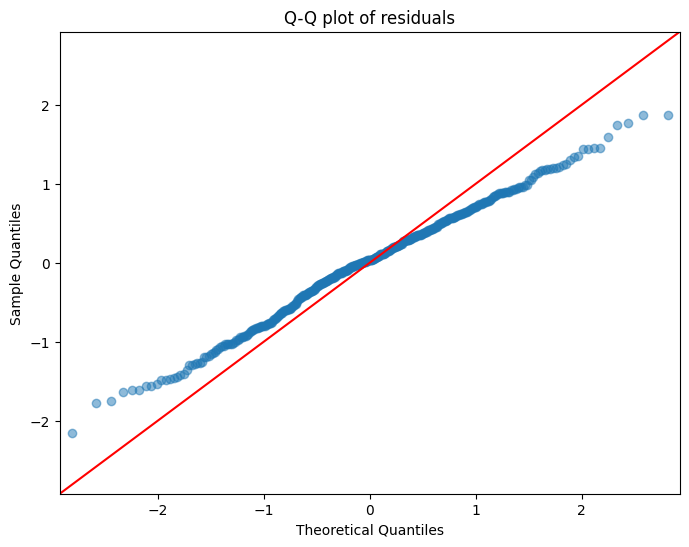

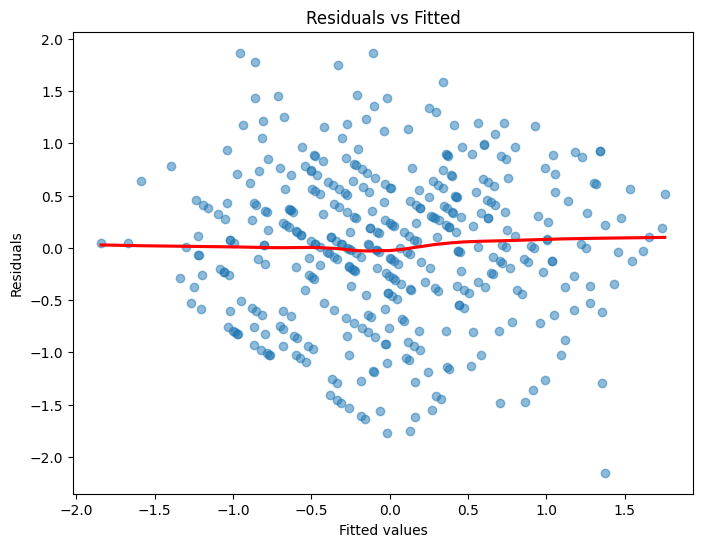

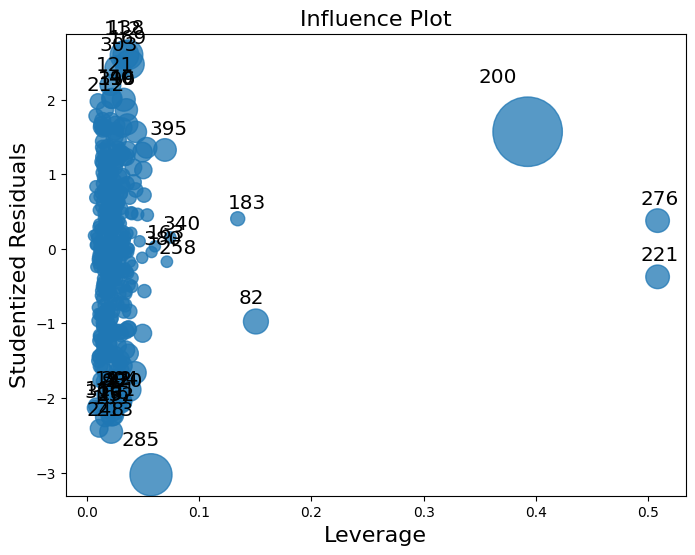

In [50]:
# Q-Q plot
fig, ax = plt.subplots(figsize=(8, 6))
QQ = ProbPlot(base_model.resid)
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax=ax)
ax.set_title('Q-Q plot of residuals')
plt.show()

# Residuals vs Fitted plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(x=base_model.fittedvalues, y=base_model.resid, lowess=True, 
            line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5}, ax=ax)
ax.set_title('Residuals vs Fitted')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
plt.show()

# Influence plot
influence = OLSInfluence(base_model)
fig, ax = plt.subplots(figsize=(8, 6))
influence.plot_influence(criterion="cooks", size=50, ax=ax)
plt.show()

# 